In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import sklearn
import sys
import os

C:\Users\matthewkent.regalado\Anaconda3\envs\project-env\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\matthewkent.regalado\Anaconda3\envs\project-env\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\matthewkent.regalado\Anaconda3\envs\project-env\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


### import to access Tagalog stopwords

In [2]:
!{sys.executable} -m pip install advertools

In [3]:
gps_df = pd.read_csv('data/play_store_reviews.csv')
as_df = pd.read_csv('data/app_store_reviews.csv')
combined_df = pd.read_csv('data/combined_reviews.csv')

# convert date columns to datetime since dtypes aren't preserved in csv files
gps_df['at'] = pd.to_datetime(gps_df['at'])
as_df['date'] = pd.to_datetime(as_df['date'])
combined_df['date'] = pd.to_datetime(combined_df['date'])

In [4]:
# drop unnecessary columns
gps_df = gps_df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1)
gps_df.head()

,content,score,at
0,Friendly user.,5,2020-08-05 06:23:06
1,nice and easy,5,2021-05-07 12:10:07
2,Amazing gcash,5,2021-04-11 06:13:37
3,Nice apps ever last thing 🔥🔥🔥🔥🔥😍😍😍😍😍😘😘😘😘😘,5,2021-02-26 01:45:39
4,Very convinience,5,2020-08-02 04:48:25


In [5]:
as_df = as_df.drop(['title', 'userName', 'isEdited', 'developerResponse'], axis=1)
as_df.head()

,date,review,rating
0,2021-02-17 06:32:13,Nakakadismaya naman. Dati okay naman yung gcas...,1
1,2020-03-24 03:28:48,Don’t ever put your money here! My transaction...,1
2,2020-09-15 16:58:57,Best as it has no fees. Wish they had rebates ...,5
3,2020-06-07 09:31:21,Gcash has been very helpful in many ways to me...,1
4,2020-09-25 09:19:47,I USED METROBANK INSTAPAY TO CASH IN BUT UNTIL...,1


In [6]:
combined_df.head()

,date,review,rating
0,2021-02-17 06:32:13,Nakakadismaya naman. Dati okay naman yung gcas...,1
1,2020-03-24 03:28:48,Don’t ever put your money here! My transaction...,1
2,2020-09-15 16:58:57,Best as it has no fees. Wish they had rebates ...,5
3,2020-06-07 09:31:21,Gcash has been very helpful in many ways to me...,1
4,2020-09-25 09:19:47,I USED METROBANK INSTAPAY TO CASH IN BUT UNTIL...,1


## Plain text to bag-of-words (BOW)
---

In [33]:
import re
import nltk
import advertools as adv
from nltk import word_tokenize          
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# concatenate english and tagalog stopwords into one list
stop_words = stopwords.words('english') + list(adv.stopwords['tagalog'])

token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matthewkent.regalado\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matthewkent.regalado\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthewkent.regalado\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize and lemmatize review data

In [36]:
import time
from sklearn.feature_extraction.text import CountVectorizer

data = []
data = as_df.review.values.tolist()
vocab_size = 2000

print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(
    input='content', 
    analyzer='word', 
    stop_words=stop_words,
    tokenizer=LemmaTokenizer(), 
    max_features=vocab_size, 
    max_df=0.95, 
    min_df=2
)

vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...


C:\Users\matthewkent.regalado\Anaconda3\envs\project-env\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 1934
Done. Time elapsed: 0.90s


### Remove reviews shorter than three words
Very short reviews won't be able to express more than a single topic

In [40]:
threshold = 3
vectors = vectors[np.array(vectors.sum(axis=1)>threshold).reshape(-1,)]
print('removed short docs (<{} words)'.format(threshold))        
print(vectors.shape)

print(f'\n{type(vectors), vectors.dtype}')
print(vectors[0])

removed short docs (<3 words)
(1508, 1934)

(<class 'scipy.sparse.csr.csr_matrix'>, dtype('int64'))
  (0, 624)	2
  (0, 671)	1
  (0, 969)	1
  (0, 1572)	1
  (0, 808)	1
  (0, 1431)	1
  (0, 1350)	1
  (0, 1662)	1
  (0, 1397)	1
  (0, 1281)	1
  (0, 286)	1
  (0, 1776)	1


### Type-cast input dat to np.float32 since all the params (i.e. weights and biases) in the NTM model will also be in that dtype
This is the more optimal approach as opposed to repeatedly type-casting during mini-batch training

In [41]:
import scipy.sparse as sparse

vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


### Split data to training (20%), validation (40%), and test (40%) datasets

In [43]:
n_train = int(0.2 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(301, 1934) (604, 1934) (603, 1934)


## Store data in S3
---

In [ ]:
import os
from sagemaker import get_execution_role

role = get_execution_role()

bucket = # <insert your own bucket name here as a string> #
prefix = 'NTM'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

## Data exploration
---

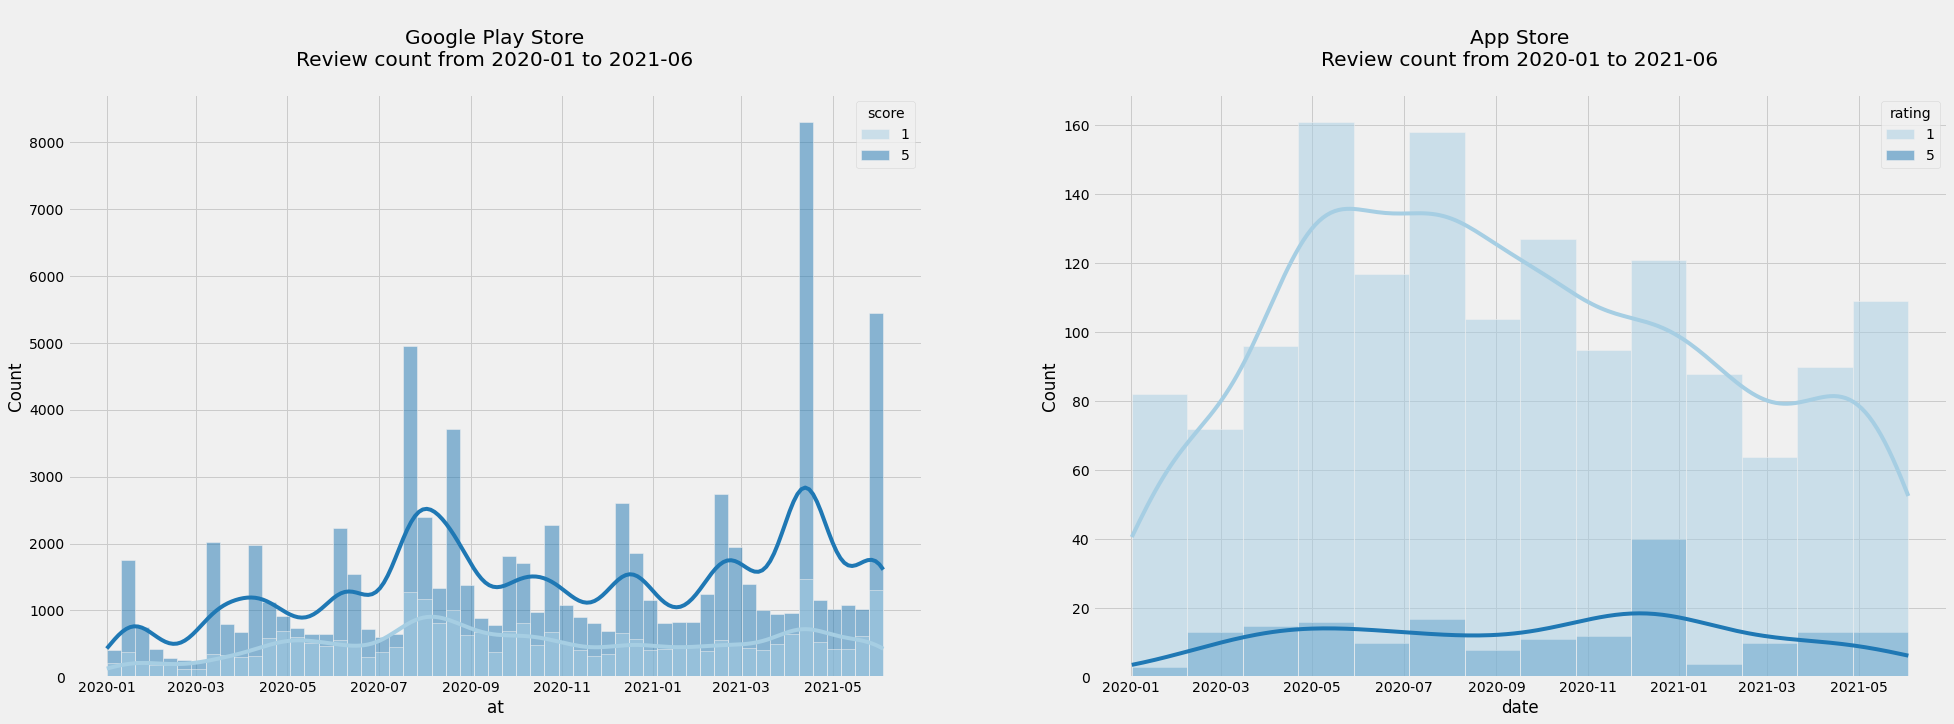

In [67]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

ps_plot = sns.histplot(ax=axes[0], data=gps_df, x='at', hue='score', palette='Paired', kde=True)
ps_plot.title.set_text('\nGoogle Play Store\nReview count from 2020-01 to 2021-06\n')
as_plot = sns.histplot(ax=axes[1], data=as_df, x='date', hue='rating', palette='Paired', kde=True)
as_plot.title.set_text('\nApp Store\nReview count from 2020-01 to 2021-06\n')

In [134]:
gps_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOEl7oPknT2b9M2Tv6OzXgSLepD5aKu8YU0nEMW...,JICS Vlog,https://play-lh.googleusercontent.com/a-/AOh14...,Friendly user.,5,0,5.30.2,2020-08-05 06:23:06,NaN,NaN
1,gp:AOqpTOFo-LetHyD2NcWIvuRHNTSyXuKVgUhU5kAAm28...,Noel Tayson,https://play-lh.googleusercontent.com/a/AATXAJ...,nice and easy,5,0,NaN,2021-05-07 12:10:07,NaN,NaN
2,gp:AOqpTOFeGgHnhKX2H9esKGPNeep2n_G17KE-CK05r3y...,Rachel Salazar,https://play-lh.googleusercontent.com/a-/AOh14...,Amazing gcash,5,0,5.39.1,2021-04-11 06:13:37,NaN,NaN
3,gp:AOqpTOH-FI8Oec_LLGXD2NiLmoFxikh_CEp34tXcPhq...,Allen Requinto,https://play-lh.googleusercontent.com/a-/AOh14...,Nice apps ever last thing 🔥🔥🔥🔥🔥😍😍😍😍😍😘😘😘😘😘,5,0,5.37.0,2021-02-26 01:45:39,NaN,NaN
4,gp:AOqpTOH-Re9DKgQdaKiabTh5jYV14Msplav15HkpDD3...,Jackielyn Yamato vlog's,https://play-lh.googleusercontent.com/a-/AOh14...,Very convinience,5,0,5.29.1,2020-08-02 04:48:25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
110601,gp:AOqpTOHA1FAaOUjWWqtHQHSMI9m3hwEBnnMfDW2YtyU...,Rovenlyn Gacad,https://play-lh.googleusercontent.com/a/AATXAJ...,Very nice its help to me in my business load,5,0,5.36.0,2021-03-25 06:39:35,NaN,NaN
110602,gp:AOqpTOHG5ZoVZlcCaZEV8gg4gYG_0LHklyzliIt-g_C...,Decass The great,https://play-lh.googleusercontent.com/a-/AOh14...,I love gcash..im happy using this app,5,0,5.38.1,2021-04-12 15:21:24,NaN,NaN
110603,gp:AOqpTOHElESM6dIg9HLw57Ebk3CF9ASF1RyKD5vMrN3...,Melody Gonzales,https://play-lh.googleusercontent.com/a/AATXAJ...,Love it,5,0,5.29.1,2020-07-22 22:47:16,NaN,NaN
110604,gp:AOqpTOGCFLWKOtJU0ToAThg6Zaack834YSsLfXnhoHu...,Willard Dequilla,https://play-lh.googleusercontent.com/a/AATXAJ...,Very nice,5,0,NaN,2021-05-28 04:05:36,NaN,NaN


## Preprocess data (GPS)
---

### Remove punctuation from all reviews

In [68]:
import string

# init empty list
clean_lst = []

# for review in as_df['review']:
for review in gps_df['content']:
    # convert each review to a string to avoid AttributeErrors while using the translate method
    str_review = str(review)
    clean_review = str_review.translate(str.maketrans('', '', string.punctuation))
    clean_lst.append(clean_review)

### Remove emojis/emoticons, flags (iOS), pictographs, and transportation and map symbols from all reviews

In [69]:
# init empty list
final_lst = []

for review in clean_lst:
    final_review = review.encode('ascii', 'ignore').decode('ascii')
    final_lst.append(final_review.lower().strip())
    
# set all strings to lowercase and split every line to strings
review_lst = [line.split() for line in final_lst]

### clean data by removing stopwords and lemmatizing each word using the nltk library

In [93]:
from nltk.corpus import wordnet

# Helper function to lemmatize with part of speech (POS) tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [103]:
# https://www.nltk.org/
# import the Natural Language Toolkit (nltk) library to further process the parsed word data
import nltk
import advertools as adv
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from nltk.stem import WordNetLemmatizer

# index value
value = 29

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(adv.stopwords['tagalog'])

# Init Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Remove stop words from each line and lemmatize each word
clean_review_lst = [[lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words if not word in stop_words] for words in review_lst]

# compare original output from 'cleaned' output 
print(f'\nOriginal (length = {len(gps_df.iloc[value, 3].split())}):\n{gps_df.iloc[value, 3].split()}')
print(f'\nPreprocessed (length = {len(clean_review_lst[value])}):\n{clean_review_lst[value]}\n')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

Original (length = 38):
['PLEASE', 'REMOVE', 'THE', 'SCHOOL', 'ID.', 'I', 'saw', 'on', 'a', 'group', 'that', 'their', 'are', 'people', 'paying', 'just', 'to', 'verify', 'an', 'account.', 'How', 'is', 'that', 'even', 'possible?', '😳', 'ITS', 'LIKE', 'SOME', 'PEOLE', 'IS', 'USING', 'YOUR', 'PLATFORM', 'TO', 'SCAM', 'OTHER', 'PEOPLE.']

Preprocessed (length = 18):
['please', 'remove', 'school', 'id', 'saw', 'group', 'people', 'pay', 'verify', 'account', 'even', 'possible', 'like', 'peole', 'use', 'platform', 'scam', 'people']



In [105]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# initialize the Tokenizer with the oov_token parameter to specify each out of vocab word with a special vocabulary token; <OOV>.
# will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence/texts_to_sequences calls
tokenizer = Tokenizer(oov_token='<OOV>')

# create tokens for every word in the review corpus
tokenizer.fit_on_texts(clean_review_lst)
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(clean_review_lst)
padded_data = pad_sequences(sequences, padding='post')

# print(f'Word index:\n{tokenizer.word_index}')

# print(f'\nOriginal:\n{as_df.iloc[17, 1]}')
print(f'\nOriginal sentence:\n{gps_df.iloc[value, 3]}')
print(f'\nPreprocessed sentence:\n{clean_review_lst[value]}')
print(f'\nTokenized sentence:\n{sequences[value]}')
print(f'\nPadded tokenized sentence:\n{padded_data[value]}')
print(f'\nShape of tokenized review corpus:\n{padded_data.shape}')


Original sentence:
PLEASE REMOVE THE SCHOOL ID. I saw on a group that their are people paying just to verify an account. How is that even possible? 😳 ITS LIKE SOME PEOLE IS USING YOUR PLATFORM TO SCAM OTHER PEOPLE.

Preprocessed sentence:
['please', 'remove', 'school', 'id', 'saw', 'group', 'people', 'pay', 'verify', 'account', 'even', 'possible', 'like', 'peole', 'use', 'platform', 'scam', 'people']

Tokenized sentence:
[33, 283, 292, 16, 1415, 3351, 224, 28, 15, 14, 35, 510, 30, 9736, 6, 933, 222, 224]

Padded tokenized sentence:
[  33  283  292   16 1415 3351  224   28   15   14   35  510   30 9736
    6  933  222  224    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]

Shape of tokenized review corpus:
(110606, 73)


## Manual train test split
---

In [14]:
# reviews = []
# labels = []

# for line in clean_review_lst:
#     temp = ' '.join(line)
#     reviews.append(temp)

# # use 20% of data for training RNN model
# training_size = int(len(reviews)*.2)

# sentiment_label = gps_df.score.factorize()
# labels = sentiment_label[0]

In [15]:
# training_sentences = reviews[0:training_size]
# testing_sentences = reviews[training_size - len(reviews):]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size - len(reviews):]

In [26]:
# tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
# tokenizer.fit_on_texts(training_sentences)

# trunc_type='post'
# padding_type='post'
# word_index = tokenizer.word_index

# training_sequences = tokenizer.texts_to_sequences(training_sentences)
# training_padded = pad_sequences(training_sequences, padding=padding_type)

# testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# testing_padded = pad_sequences(testing_sequences, padding=padding_type)

In [17]:
# # Need this block to get it to work with TensorFlow 2.x
# training_padded = np.array(training_padded)
# training_labels = np.array(training_labels)
# testing_padded = np.array(testing_padded)
# testing_labels = np.array(testing_labels)

## Build sequential RNN model
---

In [18]:
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, BatchNormalization
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import SGD, RMSprop, Adam

# embedding_vector_length = 128

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_vector_length))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(Dropout(0.2))
# # model.add(BatchNormalization())

# # model.add(LSTM(32, activation='relu'))
# # model.add(Dropout(0.2))
# # model.add(BatchNormalization())

# # model.add(Dense(16, activation='relu'))
# # model.add(Dropout(0.2))
# # model.add(Dense(32, activation='relu'))

# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['binary_accuracy'])
# model.summary()

In [98]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,  return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['binary_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          895520    
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 32)          6272      
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 16)                2624      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_12 (Dropout)         (None, 4)                

In [99]:
from keras.callbacks import ModelCheckpoint

model_path = '/kaggle/working/lstm_model.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint]

In [140]:
# sentiment_label = gps_df.rating.factorize()
# gps_df.rating.values

sentiment_label = gps_df.score.factorize()
sentiment_label

(array([0, 0, 0, ..., 0, 0, 1]), Int64Index([5, 1], dtype='int64'))

In [101]:
num_epochs = 10

# use validation_split param to split data into training and validation datasets
history = model.fit(
    padded_data,
    sentiment_label[0],
    validation_split=0.8, 
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
692/692 [==============================] - 79s 107ms/step - loss: 0.6386 - binary_accuracy: 0.7379 - val_loss: 0.4578 - val_binary_accuracy: 0.7370

Epoch 00001: val_binary_accuracy improved from -inf to 0.73703, saving model to /kaggle/working/lstm_model.h5
Epoch 2/10
692/692 [==============================] - 73s 105ms/step - loss: 0.4783 - binary_accuracy: 0.7372 - val_loss: 0.3594 - val_binary_accuracy: 0.7370

Epoch 00002: val_binary_accuracy did not improve from 0.73703
Epoch 3/10
692/692 [==============================] - 73s 105ms/step - loss: 0.3944 - binary_accuracy: 0.7369 - val_loss: 0.3091 - val_binary_accuracy: 0.7370

Epoch 00003: val_binary_accuracy did not improve from 0.73703
Epoch 4/10
692/692 [==============================] - 73s 105ms/step - loss: 0.3551 - binary_accuracy: 0.7968 - val_loss: 0.3019 - val_binary_accuracy: 0.9275

Epoch 00004: val_binary_accuracy improved from 0.73703 to 0.92755, saving model to /kaggle/working/lstm_model.h5
Epoch 5/10
69

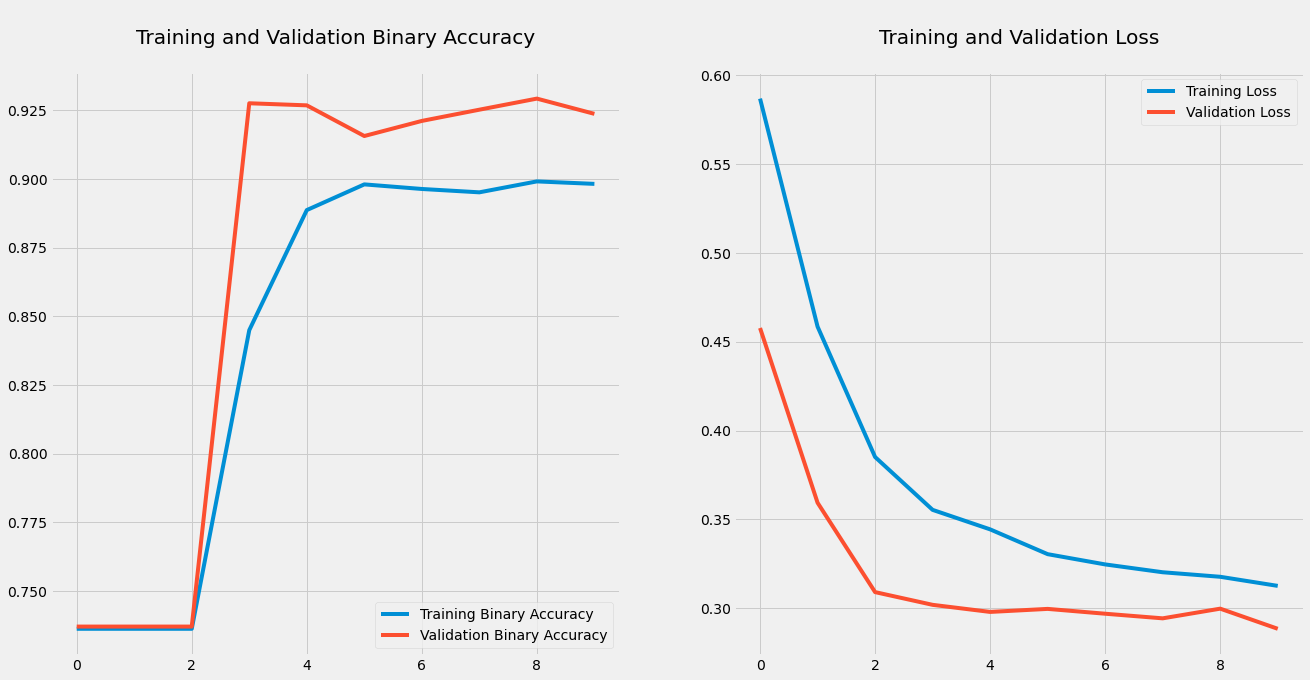

In [102]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Binary Accuracy')
plt.plot(val_acc, label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('\nTraining and Validation Binary Accuracy\n')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('\nTraining and Validation Loss\n')
plt.show()

In [106]:
# num_epochs = 10

# history = model.fit(
#     training_padded, 
#     training_labels, 
#     epochs=num_epochs, 
#     validation_data=(
#         testing_padded, 
#         testing_labels
#     ),
#     callbacks=callbacks
# )

In [107]:
# acc = history.history['binary_accuracy']
# val_acc = history.history['val_binary_accuracy']

# loss=history.history['loss']
# val_loss=history.history['val_loss']

# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Training Binary Accuracy')
# plt.plot(val_acc, label='Validation Binary Accuracy')
# plt.legend(loc='lower right')
# plt.title('\nTraining and Validation Binary Accuracy\n')

# plt.subplot(1, 2, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('\nTraining and Validation Loss\n')
# plt.show()

In [151]:
# sample_text = "This app is amazing! I loved using it"
sample_text = "This app has a lot of bugs. I hate using it. It's useless"

# preprocess input
word_lst = sample_text.encode('ascii', 'ignore').decode('ascii').translate(str.maketrans('', '', string.punctuation)).lower().split()
clean_word_lst = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_lst if not word in stop_words]

# tokenize and pad
sequences = tokenizer.texts_to_sequences(clean_word_lst)
padded_data = pad_sequences(sequences, padding='post')

# If the probability is >= 0.5, it is negative else it is positive (based on sentiment_label)
probability = model.predict(np.array([padded_data]))
prediction = 'negative' if probability >= 0.5 else 'positive'

print(f'Sentiment label:\n{sentiment_label}')
print(f'\nReview:\n{sample_text}')
print(f'\nWord list:\n{word_lst}')
print(f'\nPreprocessed:\n{clean_word_lst}')
print(f'\nTokenized review:\n{sequences}')
print(f'\nRaw probability:\n{probability}')
print(f'\nPredicted sentiment:\n{prediction}')

Sentiment label:
(array([0, 0, 0, ..., 0, 0, 1]), Int64Index([5, 1], dtype='int64'))

Review:
This app has a lot of bugs. I hate using it. It's useless

Word list:
['this', 'app', 'has', 'a', 'lot', 'of', 'bugs', 'i', 'hate', 'using', 'it', 'its', 'useless']

Preprocessed:
['app', 'lot', 'bug', 'hate', 'use', 'useless']

Tokenized review:
[[2], [104], [273], [267], [6], [154]]

Raw probability:
[[0.5755922]]

Predicted sentiment:
negative
